In [1]:
import requests
import pandas as pd
import urllib3
import sqlite3
import ryan_tools as rt
import sql_tools
import time
import numpy as np
from datetime import datetime, timedelta
import threading
requests.packages.urllib3.disable_warnings()

In [17]:
import matplotlib.pyplot as plt
from matplotlib.finance import candlestick_ohlc

def chart_candles(candles):

        ohlc = []
        for index in candles.index:
            time = index
            open_= candles.loc[index, 'open']
            high = candles.loc[index, 'high']
            low= candles.loc[index, 'low']
            close = candles.loc[index, 'close']
            ohlc.append([time, open_, high, low, close])
        
        fig = plt.figure()
        fig.set_size_inches(13, 7)
        ax1 = plt.subplot2grid((1,1), (0,0))
        candlestick_ohlc(ax1, ohlc, width=0.4)
        plt.show()

C:\Users\rfrancis\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
url = 'https://api.gdax.com'
fire = sql_tools.IcePick(sqlite3, 'fire.db')

In [3]:
check = None

In [41]:
last_message = datetime.now()

def _get( path, params=None):
    global last_message
    now = datetime.now()
    if (now - last_message).total_seconds() <= 1:
        time.sleep(1)
    r = requests.get(url + path, params=params, timeout=30, verify = False)
    if r.status_code == 429 or r.status_code == 404:
        time.sleep(2)
        r = requests.get(url + path, params=params, timeout=30, verify = False)
    global check
    check = r
    last_message = datetime.now()
    return r.json()

In [5]:
def get_time():
    return _get('/time')
def get_time_difference():
    return pd.to_datetime(get_time()['iso']) - datetime.now()
time_difference = get_time_difference()

In [6]:

def get_candles(product_id, start=None, end=None, granularity=None):
    params = {}
    if start is not None:
        start = start + time_difference
        params['start'] = start.isoformat()
    if end is not None:
        end = end + time_difference
        params['end'] = end.isoformat()
    if granularity is not None:
        params['granularity'] = granularity
    candles = _get('/products/{}/candles'.format(str(product_id)), params=params)
    candles = pd.DataFrame(candles, columns = [ 'time', 'low', 'high', 'open', 'close', 'volume' ])
    candles['time_string'] = candles['time'].apply(datetime.fromtimestamp)
    candles.sort_values('time', inplace= True)
    candles.set_index('time', inplace= True)
    return candles

In [7]:
products = _get('/products')
products = pd.DataFrame(products)

In [8]:
con = sqlite3.connect('fire.db', check_same_thread = False)

def initalize(product_ids, start_time, end_time , candle_width_seconds):
    for product_id in product_ids:
        candles = get_candles(product_id, start, end, candle_width_seconds)
        candles.to_sql(product_id, con, if_exists = 'replace')

In [9]:
def add_candles(product_id, candles):
    current = fire.get_data(product_id, ['time'])
    s1 = candles.index
    s2 = current['time']
    remove_list = pd.Series(list(set(s1).intersection(set(s2))))
    remove_list = "','".join(str(x) for x in list(remove_list))
    sql = """
    delete from [{}]
    where time in ('{}')
    
    """.format( product_id, remove_list)
    con.execute(sql)
    con.commit()
    candles.to_sql(product_id, con, if_exists = 'append')
    return 

def update_candles(product_id_list, candle_width_seconds):
    end = datetime.now()
    start = end - timedelta(seconds = candle_width_seconds * 2)
    for product_id in product_id_list:
        candles = get_candles(product_id, start=start, end=end, granularity=candle_width_seconds)
        add_candles(product_id, candles)

In [10]:
stopped = False
def keep_tuned():
    current_minute = datetime.now().minute
    global stopped
    while not stopped:
        now = datetime.now().minute
        if now != current_minute:
            update_candles(products['id'], 60.0000000000001)
            current_minute = now

In [11]:
def check_if_ok(time_cols):
    last = None
    for x in time_cols:
        ex = pd.to_datetime(x)
        if last == None:
            last = ex - timedelta(seconds = 60)
        if last != (ex - timedelta(seconds = 60)):
            print(ex)
        last = ex 

In [31]:
fire.get_data('ETH-USD')['time_string'].max()

'2017-12-15 15:09:00'

In [42]:
def fill_gap(product_id, candle_width_seconds):
    start = pd.to_datetime(fire.get_data('ETH-USD')['time'].max())
    now = datetime.now()
    while start < now:
        end = start + timedelta(seconds = 60 * 200)
        candles = get_candles(product_id, start=start, end=end, granularity=candle_width_seconds)
        add_candles(product_id, candles)
        start = end
        
fill_gap(['ETH-USD'], 60)

ValueError: If using all scalar values, you must pass an index

In [12]:
end = datetime.now() - timedelta(seconds = 60 * 60 * 12)
start = end - timedelta(seconds = 60 * 200)
initalize(products['id'], start, end, 60.0000000000001)
tuner = threading.Thread(target = keep_tuned)
tuner.start()

In [26]:
candles = fire.get_data('LTC-USD')
candles.set_index('time', inplace= True)

In [22]:
import keras

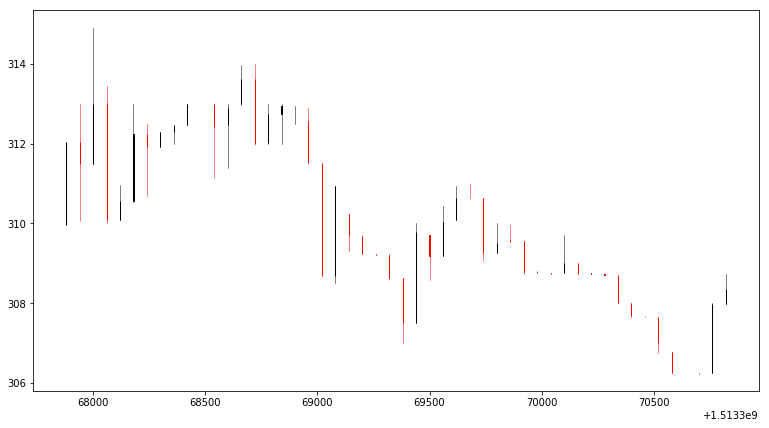

In [28]:
def get_jumpsize(candles):
    last_low = candles.iloc[-1]['low']
    third_last_high = candles.iloc[-3]['high']
    percentage_difference = (last_low - third_last_high  )/third_last_high
    if percentage_difference > 0.005:
        chart_candles(candles)
        return 1
    return 0 

def get_X_y(candles, time_steps):
    X = []
    y = []
    for num in range(0, len(candles) - time_steps):
        start = num
        end = start + time_steps
        current = candles.iloc[start:end].copy()
        y.append(get_jumpsize(current))
        current = current.iloc[0:time_steps-3]
        first_open = current.iloc[0]['open']
        first_volume = current.iloc[0]['volume']
        current[['low', 'high', 'open', 'close']] = (current[['low', 'high', 'open', 'close']] - first_open)/first_open
        current['volume'] = (current['volume'] - first_volume)/first_volume
        X.append(current[['low', 'high', 'open', 'close', 'volume']].values)
        
    return np.array(X) , np.array(y)


X, y = get_X_y(candles.iloc[0:100], 50)